In [6]:
import pandas as pd
import glob
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import gc
from scipy.stats import nct, laplace_asymmetric
import pandas_ta as ta
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


In [7]:
import import_ipynb
from I_asset_returns import HistoricalPrice
from X_market_regime_clustering import RandomVariable, RegimeClustering
hp = HistoricalPrice()

In [8]:
asset = 'TRA'
file = f"../data/{asset}_historical_price.csv"
order = f"../data/{asset}_historical_order.csv"
df = hp.read(file)
order = hp.get_order_info(order)
df.head()

,adj_close,close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value,open,high,low,volume
date,,,,,,,,,,
2008-11-26,63.5,63.5,630,40005000,0,0,63.5,63.5,63.5,630
2008-11-27,60.5,60.5,20,1240000,0,0,63.5,63.5,60.5,20
2008-11-28,57.5,57.5,150,8625000,0,0,57.5,57.5,57.5,150
2008-12-01,55.0,55.0,10,550000,0,0,57.5,55.0,55.0,10
2008-12-02,52.5,52.5,100,5250000,0,0,52.5,52.5,52.5,100


In [9]:
order = order.replace(0, np.nan).interpolate()
order = order.replace(np.inf, np.nan).interpolate()
order.head()

,SoLenhMua,KLDatMua,KLTB1LenhMua,SoLenhDatBan,KLDatBan,KLTB1LenhBan,ChenhLechKL
Date,,,,,,,
2023-08-16,16.0,2500.0,156.25,15.0,8600.0,573.0,-6100.0
2023-08-15,21.0,3700.0,176.19,12.0,4100.0,342.0,-400.0
2023-08-14,28.0,10100.0,360.71,22.0,8700.0,395.0,1400.0
2023-08-11,18.0,2300.0,127.78,21.0,12400.0,590.0,-10100.0
2023-08-10,23.0,2800.0,121.74,13.0,5000.0,385.0,-2200.0


In [10]:
df = df.join(order)
df = df.dropna()
df.head()

,adj_close,close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value,open,high,low,volume,SoLenhMua,KLDatMua,KLTB1LenhMua,SoLenhDatBan,KLDatBan,KLTB1LenhBan,ChenhLechKL
date,,,,,,,,,,,,,,,,,
2008-11-26,63.5,63.5,630,40005000,0,0,63.5,63.5,63.5,630,4.0,630.0,157.5,91.0,346760.0,3811.0,-346130.0
2008-11-27,60.5,60.5,20,1240000,0,0,63.5,63.5,60.5,20,2.0,20.0,10.0,55.0,241630.0,4393.0,-241610.0
2008-11-28,57.5,57.5,150,8625000,0,0,57.5,57.5,57.5,150,1.0,150.0,150.0,40.0,176400.0,4410.0,-176250.0
2008-12-01,55.0,55.0,10,550000,0,0,57.5,55.0,55.0,10,1.0,10.0,10.0,32.0,95750.0,2992.0,-95740.0
2008-12-02,52.5,52.5,100,5250000,0,0,52.5,52.5,52.5,100,1.0,100.0,100.0,20.0,70310.0,3516.0,-70210.0


In [11]:
##### Set sample weights equal to returns
##### Periods with high absolute returns are given more importance when training
##### THE model would place more importance on predicitng those high returns/losses more accurately because they affect our profit/loss more

df['returns'] = (df['close']/df['close'].shift(1) - 1)
df.head()

,adj_close,close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value,open,high,low,volume,SoLenhMua,KLDatMua,KLTB1LenhMua,SoLenhDatBan,KLDatBan,KLTB1LenhBan,ChenhLechKL,returns
date,,,,,,,,,,,,,,,,,,
2008-11-26,63.5,63.5,630,40005000,0,0,63.5,63.5,63.5,630,4.0,630.0,157.5,91.0,346760.0,3811.0,-346130.0,NaN
2008-11-27,60.5,60.5,20,1240000,0,0,63.5,63.5,60.5,20,2.0,20.0,10.0,55.0,241630.0,4393.0,-241610.0,-0.047244
2008-11-28,57.5,57.5,150,8625000,0,0,57.5,57.5,57.5,150,1.0,150.0,150.0,40.0,176400.0,4410.0,-176250.0,-0.049587
2008-12-01,55.0,55.0,10,550000,0,0,57.5,55.0,55.0,10,1.0,10.0,10.0,32.0,95750.0,2992.0,-95740.0,-0.043478
2008-12-02,52.5,52.5,100,5250000,0,0,52.5,52.5,52.5,100,1.0,100.0,100.0,20.0,70310.0,3516.0,-70210.0,-0.045455


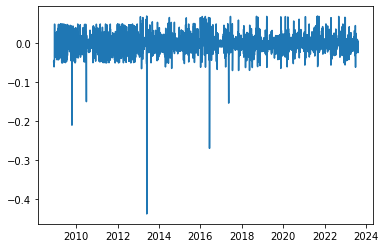

In [12]:
plt.plot(df['returns'])
plt.show()

#### Train Test Split: need to avoid data leakage

In [13]:
# split = int(df.shape[0]*0.8)
# train = df.iloc[:split]
# test = df.iloc[split:]
# train.shape,test.shape

In [14]:
# alpha = 
# train.loc[train.loc[(train['returns'] >= train['returns'].quantile(1-alpha))].index,f'upper_quantile_{1-alpha}'] = 1'returns'
# train[f'upper_quantile_{1-alpha}'] = train[f'upper_quantile_{1-alpha}'].fillna(0)

In [15]:
def days_since_quantile(df,alpha):
    df.loc[df.loc[(df['returns'] >= df['returns'].quantile(1-alpha))].index,f'upper_quantile_{1-alpha}'] = 1
    df[f'upper_quantile_{1-alpha}'] = df[f'upper_quantile_{1-alpha}'].fillna(0)
    df[f'days_since_upper_quantile_{1-alpha}'] = df.groupby(df[f'upper_quantile_{1-alpha}'].astype(bool).cumsum()).cumcount()
    # df = df.sort_index(ascending=False)

    ### days since next large loss
    df.loc[df.loc[(df['returns'] <= df['returns'].quantile(alpha))].index,f'lower_quantile_{alpha}'] = 1
    df[f'lower_quantile_{alpha}'] = df[f'lower_quantile_{alpha}'].fillna(0)
    df[f'days_since_lower_quantile_{alpha}'] = df.groupby(df[f'lower_quantile_{alpha}'].astype(bool).cumsum()).cumcount()
    # df = df.sort_index(ascending=False)
    df = df.drop(columns=[f'upper_quantile_{1-alpha}',f'lower_quantile_{alpha}'])    
    return df.sort_index(ascending=True)


def get_days_since_quantiles(df):
    alphas = [0.01] + [i for i in np.arange(0.05,0.5,0.05)]
    for a in alphas:
        df = days_since_quantile(df,a)
    return df

####### PROBLEM: LEAKAGE, quantile currently based on both train and set set. QUANTILE should be based on training data only


##### TIME SINCE QUANTILE
#### if last day was quantile 0.6 then days_since_q0.6= 1 
#### next day if quantile 0.6 again then days_since_q0.6 = 1 again
#### NO MEMORY of consecutive quantile 0.6 

#### MORE FEATURE IDEAS: number of consecutive quantile above level 
#####
# days_since_quantile(df,0.01)

# print(df.shape)
# df = get_days_since_quantiles(df)
# print(df.shape)
# df.head(10)

In [16]:
 # days_since_quantile(df,0.05)

In [17]:
target_col = 'returns'

df[target_col] = df[target_col].shift(-1).dropna()
df = df.iloc[:-1]

X = df.drop(columns=[target_col])
X = X.reindex(sorted(X.columns), axis=1)
y = df.loc[:,target_col]


split = int(X.shape[0]*0.8)

X_train = X.iloc[:split]
X_test = X.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2928, 17) (732, 17) (2928,) (732,)


In [252]:
### Feature engineering after splitting train/test. To avoid leakage of info from train into test via technical inidicators such as MA, RSI, time lag shifting etc
### IDEA TAKEN FROM PURGING/EMBARGOING from Financial ML textbook

def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df['vwma'] = df.ta.vwma(lenght=5)
    df['vwma_10'] = df.ta.vwma(length=10)
    df['vwma_20'] = df.ta.vwma(length=20)
    df['obv'] = df.ta.obv()
    
    df['rsi'] = df.ta.rsi()
    df[['adx','dmp','dmn']] = df.ta.adx()
    df[['macd','macd_histogram','macd_signal']] = df.ta.macd()
    
    lag_cols = ['adj_close','close','low','high','open']
    for lag in range(1,6):
        for i in lag_cols:
            df[f'{i}_lag{lag}'] = df[i].shift(lag)
        
    return df.dropna()

In [253]:
#### FEATURE ENGINEERING
X_train = feature_engineer(X_train)
y_train = y_train.iloc[-X_train.shape[0]:].to_frame()

X_test = feature_engineer(X_test)
y_test = y_test.iloc[-X_test.shape[0]:].to_frame()

X_train.shape,y_train.shape,X_test.shape,y_test.shape

C:\Users\admin\AppData\Local\Temp/ipykernel_8848/1212851481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vwma'] = df.ta.vwma(lenght=5)
C:\Users\admin\AppData\Local\Temp/ipykernel_8848/1212851481.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vwma_10'] = df.ta.vwma(length=10)
C:\Users\admin\AppData\Local\Temp/ipykernel_8848/1212851481.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

((2895, 57), (2895, 1), (699, 57), (699, 1))

### Random Forest

In [254]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error as mse

# rfc = rf(random_state=0,n_estimators = 1000,criterion='squared_error')
rfc = rf(random_state=0,
n_estimators= 100,
 min_samples_split= 3,
 min_samples_leaf= 6,
 max_depth= 8,
criterion='squared_error')

rfc.fit(X_train, y_train)
# # # Predict the Test set results
y_pred = rfc.predict(X_test).reshape(-1,1)

print(f'MSE {mse(y_test, y_pred)}')
results = pd.DataFrame(np.hstack((y_test,y_pred)),columns=['target','pred'],index=y_test.index)
results.head()

C:\Users\admin\AppData\Local\Temp/ipykernel_8848/1890864763.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


MSE 0.00028137586876906883


,target,pred
date,,
2020-10-21,0.000000,-0.002256
2020-10-22,0.000000,-0.002874
2020-10-23,0.016129,-0.001408
2020-10-26,-0.015873,-0.000995
2020-10-27,-0.022581,0.003076


Text(0, 0.5, 'frequency (days or weeks)')

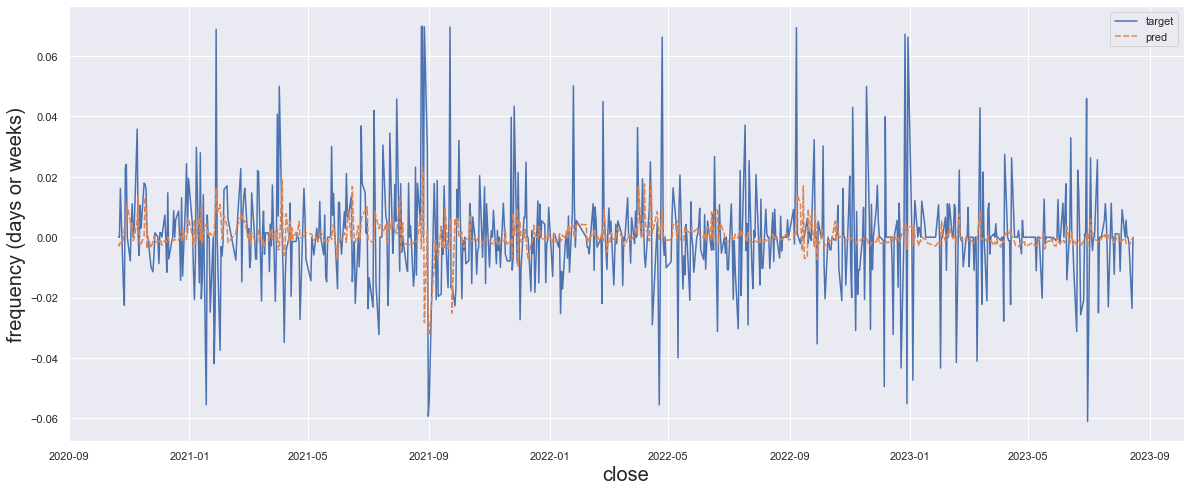

In [255]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8)})

res_plot = results#.join(X_test.loc[:,['rsi']])
plot = sns.lineplot(data=res_plot)
plot.set_xlabel('close', fontsize = 20)
plot.set_ylabel('frequency (days or weeks)', fontsize = 20)


In [256]:
results.head()

,target,pred
date,,
2020-10-21,0.000000,-0.002256
2020-10-22,0.000000,-0.002874
2020-10-23,0.016129,-0.001408
2020-10-26,-0.015873,-0.000995
2020-10-27,-0.022581,0.003076


In [265]:
sign_agreement = results['target'].values*results['pred'].values
sign_agreement = sign_agreement[sign_agreement != 0]
np.sum(sign_agreement>0)/len(sign_agreement)

0.5722326454033771

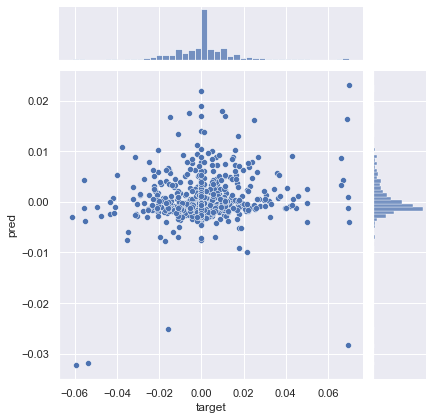

In [257]:
sns.jointplot(x=results['target'],y=results['pred'])

In [217]:
####  MSE of individual stock

### VPI: construction and real estate  57.12 
### CKG: construction and real estate  1.36
### SZC: real estate  10.53

### TRA: pharmaceutical manufacturing  9.64
### DBD: pharmaceutical manufacturing  6.38

### OCB: banking/finance 0.59
### HAH: transportation and warehousing  224.16 (poor predictive power)  
### FTS: securities brokerage 44.44 (poor predictive power)
### CAV: electrical equipment and telecom manufacturing  6.28
### BMP: plastics and rubber manufacturing  11.31

### reduced portfolio taking into account predictability 
['BMP','CAV','OCB','DBD','TRA']
#### porfolio optimization yield equal weight 20% for each
### and OCB can be used for pair-trading

import joblib
joblib.dump(rfc, f"random_forest_{asset}.joblib")

['random_forest_TRA.joblib']

#### Hyperparameter Tuning

In [37]:
from sklearn.model_selection import GridSearchCV as GSCV

# Minimum number of samples required to split a node
min_samples_split = [x for x in range(3,7,1)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [x for x in range(3,7,1)]

# Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': [100,200,300,400,500,600,700,800],
               'max_depth': [8],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_depth': [8], 'min_samples_split': [3, 4, 5, 6], 'min_samples_leaf': [3, 4, 5, 6]}


In [ ]:
rf_random = GSCV(estimator = rfc, param_grid = random_grid, cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

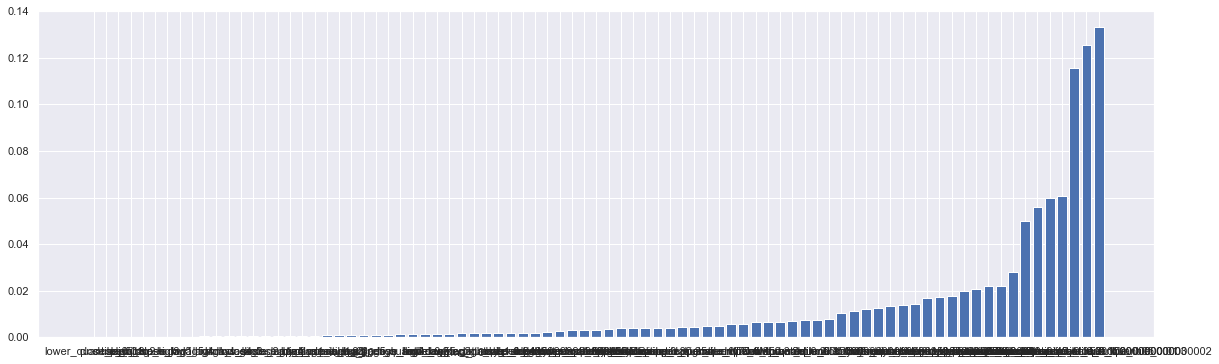

In [1341]:
sorted_imp = rfc.feature_importances_.argsort()
plt.figure(figsize=(20,6))
plt.bar(X_train.columns[sorted_imp], rfc.feature_importances_[sorted_imp])
plt.show()

In [1342]:
for i in X_train.columns[sorted_imp]:
    print(i)

lower_quantile_0.01
close_lag5
close_lag3
open_lag2
adj_close_lag3
adj_close_lag5
open_lag1
high_lag5
low_lag4
high
vwma
high_lag4
low_lag3
close_lag2
close_lag1
close_lag4
days_since_upper_quantile_0.6
low_lag1
adj_close_lag1
adj_close_lag2
open_lag3
vwma_20
low_lag5
days_since_upper_quantile_0.55
adj_close_lag4
high_lag2
low
high_lag3
close
low_lag2
vwma_10
order_negotiated_value
high_lag1
days_since_upper_quantile_0.6499999999999999
open_lag4
open_lag5
adj_close
order_negotiated_volume
days_since_upper_quantile_0.7
lower_quantile_0.45
lower_quantile_0.4
order_matching_volume
days_since_upper_quantile_0.8
SoLenhMua
KLDatBan
order_matching_value
lower_quantile_0.25
days_since_upper_quantile_0.75
macd_signal
days_since_upper_quantile_0.85
rsi
open
dmp
lower_quantile_0.3
KLDatMua
macd
lower_quantile_0.2
lower_quantile_0.1
dmn
lower_quantile_0.05
SoLenhDatBan
lower_quantile_0.35000000000000003
macd_histogram
volume
adx
ChenhLechKL
obv
days_since_lower_quantile_0.25
days_since_upper_quant